# __Demo: Generating Fake Images with Generative Adversarial Networks (GANs)__

# __Steps to Perform__

Step 1: Import the Necessary Libraries

Step 2: Load and Preprocess the Data

Step 3: Build the Generator and Discriminator

Step 4: Compile the Models

Step 5: Train the Models

Step 6: Execute the Training

Step 7: Generate New Images and Evaluate the Model's Performance



# __Step 1: Import the Necessary Libraries__

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten
from tensorflow.keras.models import Sequential
import numpy as np

# __Step 2: Load and Preprocess the Data__

- Load the MNIST dataset and preprocess it.
- Preprocessing involves normalizing the data that can improve models' performance.

In [2]:
# Load MNIST data
(X_train, _), (_, _) = mnist.load_data()
# Normalize to between -1 and 1
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3) # Add channel dimension

# __Step 3: Build the Generator and Discriminator__

- Define the generator and discriminator models.
- Generator takes a random noise vector as input and outputs an image.
- Discriminator takes an image as input and outputs the probability of the image being real.

In [3]:
# Generator
def create_generator():
    model = Sequential()
    model.add(Dense(256, input_dim=100, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(784, activation='tanh'))
    model.add(Reshape((28, 28, 1)))
    return model

# Discriminator
def create_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28, 1)))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

# __Step 4: Compile the Models__

- Compile the models, which involves defining the loss function and the optimizer.
- The loss function evaluates the model's performance, while the optimizer aims to minimize the loss.

In [4]:
from tensorflow.keras.models import Sequential, Model

# Create and compile the discriminator
discriminator = create_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer='adam')

# Create and compile the generator
generator = create_generator()
generator.compile(loss='binary_crossentropy', optimizer='adam')

# Create and compile the combined model
discriminator.trainable = False
gan_input = Input(shape=(100,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = Model(inputs=gan_input, outputs=gan_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')

/Users/balaji/Library/CloudStorage/GoogleDrive-bala@python4u.in/My Drive/Balaji Personal/Simplilearn_SquareRootz/Advanced_Gen_AI_Oct/iitk_advanced_gen_ai/iitk_gen_ai_course/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-01-21 17:26:21.968038: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-01-21 17:26:21.968114: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-01-21 17:26:21.968135: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-01-21 17:26:21.968391: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025

# __Step 5: Train the Models__

- Train the model, which involves feeding data into the models and adjusting the weights of the models based on the output.
- The primary aim is for the generator to create images indistinguishable from real images by the discriminator.

In [5]:
def train(epochs=1, batch_size=128):
    """
    Train a Generative Adversarial Network (GAN) on the MNIST dataset.
    
    This function implements the GAN training process where two networks compete:
    1. Generator: Creates fake images from random noise
    2. Discriminator: Tries to distinguish real images from fake ones
    
    The training follows these steps for each batch:
    1. Train discriminator on real images (label=1)
    2. Train discriminator on fake images (label=0)
    3. Train generator to fool discriminator (wants label=1 for fake images)
    
    Args:
        epochs (int): Number of complete passes through the training dataset
        batch_size (int): Number of images to process in each training step
    
    Note:
        - Uses MNIST dataset (28x28 grayscale images of digits)
        - Generator input: 100-dimensional random noise vector
        - Labels are slightly noised (0.9 instead of 1.0) to prevent overconfidence
    """
    # Load MNIST dataset and preprocess
    # We only need training images (X_train), labels are ignored (_)
    (X_train, _), (_, _) = mnist.load_data()
    
    # Normalize pixel values to range [-1, 1] for better training stability
    # First subtract 127.5 then divide by 127.5 to convert from [0, 255] to [-1, 1]
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    
    # Add channel dimension for CNN (shape becomes [n_samples, 28, 28, 1])
    # Required because CNNs expect input shape: [batch_size, height, width, channels]
    X_train = np.expand_dims(X_train, axis=3)

    # Create labels for training
    # Ones for real images (slightly noised later to prevent discriminator overconfidence)
    y_train_ones = np.ones((batch_size, 1))
    # Zeros for fake images
    y_train_zeros = np.zeros((batch_size, 1))
    # Labels for evaluation (not used in this code snippet)
    y_test_ones = np.ones((100, 1))

    # Main training loop - iterate through specified number of epochs
    for e in range(epochs):
        # Inner loop - process dataset in batches
        # X_train.shape[0] // batch_size gives number of batches per epoch
        for i in range(X_train.shape[0] // batch_size):
            
            # PART 1: TRAIN DISCRIMINATOR
            # Enable discriminator training (might have been disabled in previous step)
            discriminator.trainable = True

            # Train on real images
            # Extract current batch of real images
            X_batch = X_train[i*batch_size:(i+1)*batch_size]
            # Train discriminator on real images with slightly noisy labels
            # Instead of 1, use values between 0.9 and 1.0 to prevent overconfidence
            d_loss_real = discriminator.train_on_batch(
                x=X_batch, 
                y=y_train_ones * (1 - 0.1 * np.random.rand(batch_size, 1))
            )

            # Train on fake images
            # Generate random noise vectors (for generator input)
            z_noise = np.random.normal(loc=0, scale=1, size=(batch_size, 100))
            # Create fake images using generator
            X_fake = generator.predict_on_batch(z_noise)
            # Train discriminator to recognize fake images (label = 0)
            d_loss_fake = discriminator.train_on_batch(x=X_fake, y=y_train_zeros)

            # Calculate total discriminator loss (average of real and fake losses)
            d_loss = 0.5 * (d_loss_real + d_loss_fake)

            # PART 2: TRAIN GENERATOR
            # Disable discriminator training while training generator
            discriminator.trainable = False
            # Train generator to fool discriminator
            # Note: Generator wants discriminator to output 1 (real) for fake images
            g_loss = gan.train_on_batch(x=z_noise, y=y_train_ones)

            # Print progress
            print(f'Epoch: {e+1}, Batch: {i}, D Loss: {d_loss}, G Loss: {g_loss}')

# __Step 6: Execute the Training__

In [6]:
# Call the train function
train(epochs=50, batch_size=128)

2025-01-21 19:40:52.334614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Epoch: 1, Batch: 0, D Loss: 0.8652907609939575, G Loss: 0.9494042992591858
Epoch: 1, Batch: 1, D Loss: 1.572655439376831, G Loss: 0.9917482137680054
Epoch: 1, Batch: 2, D Loss: 1.7735915184020996, G Loss: 0.9885795712471008
Epoch: 1, Batch: 3, D Loss: 1.544203281402588, G Loss: 1.0498664379119873
Epoch: 1, Batch: 4, D Loss: 4.621644020080566, G Loss: 1.0527267456054688
Epoch: 1, Batch: 5, D Loss: 5.218852996826172, G Loss: 1.0252439975738525
Epoch: 1, Batch: 6, D Loss: 4.551501274108887, G Loss: 1.0118354558944702
Epoch: 1, Batch: 7, D Loss: 4.115857124328613, G Loss: 1.0241771936416626
Epoch: 1, Batch: 8, D Loss: 3.834392547607422, G Loss: 1.0303491353988647
Epoch: 1, Batch: 9, D Loss: 3.5994231700897217, G Loss: 1.0289826393127441
Epoch: 1, Batch: 10, D Loss: 3.383479595184326, G Loss: 1.0267714262008667
Epoch: 1, Batch: 11, D Loss: 3.1739797592163086, G Loss: 1.0483511686325073
Epoch: 1, Batch: 12, D Loss: 2.9711828231811523, G Loss: 1.0707197189331055
Epoch: 1, Batch: 13, D Loss: 2

**Notes:**
- Epochs parameter determines how many times the learning algorithm will work through the entire training dataset.
- The `batch_size` is the number of samples that will be propagated through the network at a time.

# __Step 7: Generate New Images and Evaluate the Model's Performance__

- Generate new images and evaluate the performance of the GAN.
- Generate a random noise vector and feed it into the trained generator to create new images.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


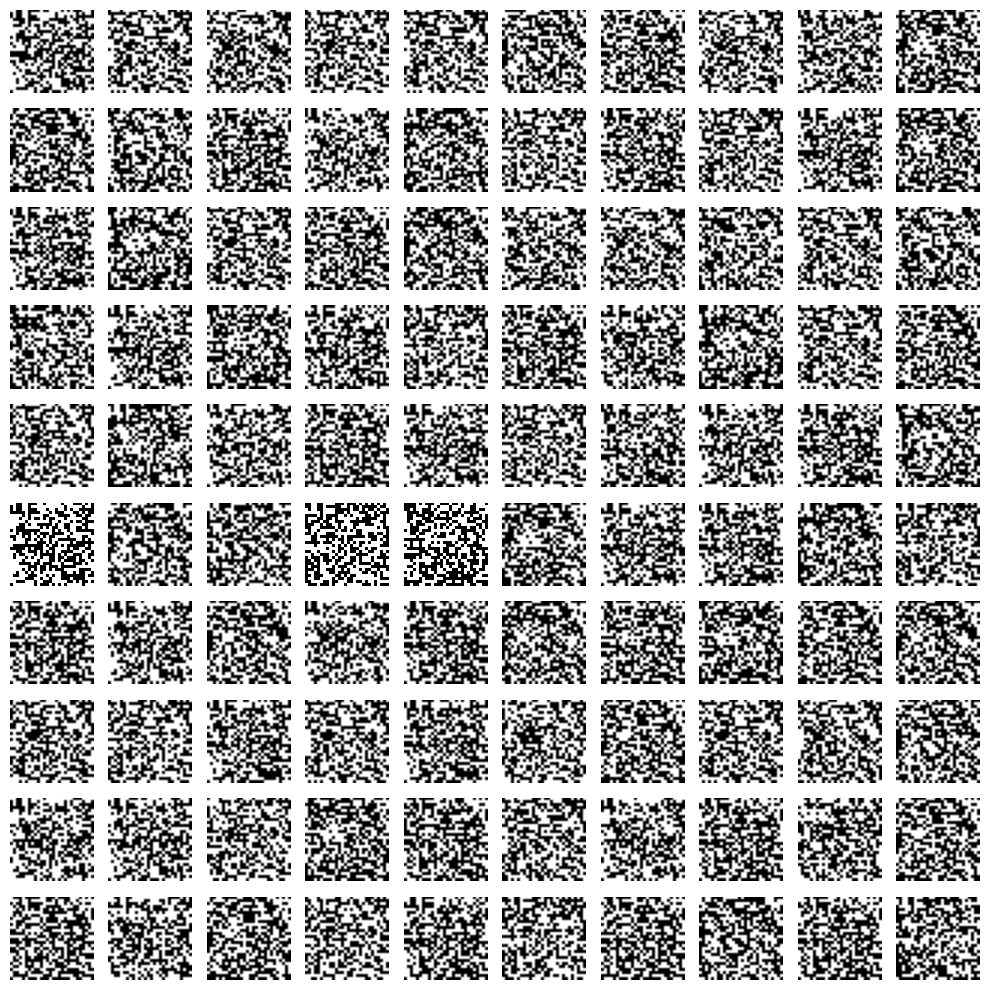

In [9]:
import matplotlib.pyplot as plt
# Generate random noise as an input to initialize the generator
random_noise = np.random.normal(0,1, [100, 100])

# Generate the images from the noise
generated_images = generator.predict(random_noise)

# Visualize the generated images
plt.figure(figsize=(10,10))
for i in range(generated_images.shape[0]):
    plt.subplot(10, 10, i+1)
    plt.imshow(generated_images[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

- The resulting plot shows the images generated by the GAN model.

**Notes:**

The output effectively demonstrates how model can generate images resembling handwritten digit 8. However, there is room for improving the quality of these images.

# __Conclusion__

In this demo, you have successfully implemented a GAN to generate images resembling handwritten digits, focusing on the MNIST dataset. The process involved constructing and training a generator and a discriminator. The results were promising, showcasing the GAN's ability to create images similar to the digit **8**, but also highlighted the need for further improvements in image quality.